# Прогноз часового спроса такси по районам — улучшенная версия

## Пайплайн предобработки / FE / генерации данных

In [22]:
import os
import glob
import zipfile
import gdown
import holidays
import pandas as pd
import numpy as np
from meteostat import Stations, Hourly
from datetime import datetime
from pathlib import Path

In [23]:
def load_raw_data() -> pd.DataFrame:
    current_dir = Path().resolve()
    target_dir = current_dir.parent / 'mfdp_data'

    file_paths = [f for f in target_dir.iterdir() if f.is_file()]
    dfs = []
    for path in file_paths:
        df = pd.read_parquet(path)
        fname = str(path).lower()
        if 'yellow' in fname:
            df = df.rename(columns={'tpep_pickup_datetime': 'pickup_datetime', 'PULocationID': 'location_id'})
        elif 'green' in fname:
            df = df.rename(columns={'lpep_pickup_datetime': 'pickup_datetime', 'PULocationID': 'location_id'})
        elif 'fhvhv' in fname:
            df = df.rename(columns={'pickup_datetime': 'pickup_datetime', 'PULocationID': 'location_id'})
        if 'pickup_datetime' in df.columns and 'location_id' in df.columns:
            df = df[['pickup_datetime', 'location_id']]
            df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
            df = df.dropna().drop_duplicates()
            dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True).drop_duplicates().reset_index(drop=True)
    combined = combined[(combined['pickup_datetime'] >= '2024-01-01') & (combined['pickup_datetime'] < '2025-04-01')]
    combined['date'] = combined['pickup_datetime'].dt.date
    combined['hour'] = combined['pickup_datetime'].dt.hour
    combined = combined.drop(columns=['pickup_datetime'])
    return combined

In [24]:
def aggregate_trips(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby(['date', 'hour', 'location_id']).size().reset_index(name='trips_count')

In [25]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    us_holidays = holidays.US()
    non_working = {'New Year\'s Day', 'MLK Day', 'Washington\'s Birthday', 'Memorial Day',
                   'Juneteenth', 'Independence Day', 'Labor Day', 'Thanksgiving', 'Christmas Day'}
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_holiday'] = df['date'].apply(lambda d: us_holidays.get(d.date()) in non_working)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_pre_holiday'] = df['date'].shift(-1).apply(lambda d: us_holidays.get(d.date()) in non_working)
    df['is_post_holiday'] = df['date'].shift(1).apply(lambda d: us_holidays.get(d.date()) in non_working)
    df['lag_1h'] = df.groupby('location_id')['trips_count'].shift(1).fillna(0)
    df['lag_24h'] = df.groupby('location_id')['trips_count'].shift(24).fillna(0)
    df['lag_168h'] = df.groupby('location_id')['trips_count'].shift(168).fillna(0)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    roll = df.groupby('location_id')['trips_count'].rolling(168, min_periods=1)
    df['roll_168h_mean'] = roll.mean().reset_index(level=0, drop=True)
    df['roll_168h_median'] = roll.median().reset_index(level=0, drop=True)
    df['roll_168h_std'] = roll.std().reset_index(level=0, drop=True).fillna(0)
    df['time_idx'] = df.groupby('location_id').cumcount()
    return df

In [26]:
def merge_weather(df: pd.DataFrame) -> pd.DataFrame:
    start = datetime(2024, 1, 1)
    end = datetime(2025, 5, 1)
    station = Stations().nearby(40.7128, -74.0060).fetch(1).index[0]
    weather = Hourly(station, start, end).fetch().reset_index()
    weather['date'] = weather['time'].dt.date
    weather['hour'] = weather['time'].dt.hour
    weather = weather[['date', 'hour', 'temp', 'prcp', 'wspd']]
    weather['date'] = pd.to_datetime(weather['date'])
    return df.merge(weather, on=['date', 'hour'], how='left')

In [27]:
def save_data(df: pd.DataFrame, output: str='result_lstm.csv') -> pd.DataFrame:
    df['datetime'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['hour'].astype(str) + ':00')
    df = df.sort_values(['location_id', 'datetime']).reset_index(drop=True)
    df = df.drop(['datetime'], axis=1)
    df.to_csv(output, index=False)
    df.head(n=100).to_csv('result_lstm_test.csv', index=False)
    return df

In [28]:
def pipeline() -> pd.DataFrame:
    df = load_raw_data()
    df = aggregate_trips(df)
    df = engineer_features(df)
    df = merge_weather(df)
    df = save_data(df)
    return df

In [29]:
df1 = load_raw_data()
df1.head()

,location_id,date,hour
0,161,2024-01-01,0
1,137,2024-01-01,0
2,79,2024-01-01,0
3,234,2024-01-01,0
4,148,2024-01-01,0


In [30]:
df2 = aggregate_trips(df1)
df2.head()

,date,hour,location_id,trips_count
0,2024-01-01,0,3,73
1,2024-01-01,0,4,281
2,2024-01-01,0,5,19
3,2024-01-01,0,6,32
4,2024-01-01,0,7,579


In [31]:
df3 = engineer_features(df2)
df3.head()

,date,hour,location_id,trips_count,day_of_week,month,is_weekend,is_holiday,is_month_start,is_month_end,...,lag_24h,lag_168h,hour_sin,hour_cos,dow_sin,dow_cos,roll_168h_mean,roll_168h_median,roll_168h_std,time_idx
0,2024-01-01,0,3,73,0,1,0,True,1,0,...,0.0,0.0,0.0,1.0,0.0,1.0,73.0,73.0,0.0,0
1,2024-01-01,0,4,281,0,1,0,True,1,0,...,0.0,0.0,0.0,1.0,0.0,1.0,281.0,281.0,0.0,0
2,2024-01-01,0,5,19,0,1,0,True,1,0,...,0.0,0.0,0.0,1.0,0.0,1.0,19.0,19.0,0.0,0
3,2024-01-01,0,6,32,0,1,0,True,1,0,...,0.0,0.0,0.0,1.0,0.0,1.0,32.0,32.0,0.0,0
4,2024-01-01,0,7,579,0,1,0,True,1,0,...,0.0,0.0,0.0,1.0,0.0,1.0,579.0,579.0,0.0,0


In [32]:
df4 = merge_weather(df3)
df4.head()

,date,hour,location_id,trips_count,day_of_week,month,is_weekend,is_holiday,is_month_start,is_month_end,...,hour_cos,dow_sin,dow_cos,roll_168h_mean,roll_168h_median,roll_168h_std,time_idx,temp,prcp,wspd
0,2024-01-01,0,3,73,0,1,0,True,1,0,...,1.0,0.0,1.0,73.0,73.0,0.0,0,6.0,0.0,11.0
1,2024-01-01,0,4,281,0,1,0,True,1,0,...,1.0,0.0,1.0,281.0,281.0,0.0,0,6.0,0.0,11.0
2,2024-01-01,0,5,19,0,1,0,True,1,0,...,1.0,0.0,1.0,19.0,19.0,0.0,0,6.0,0.0,11.0
3,2024-01-01,0,6,32,0,1,0,True,1,0,...,1.0,0.0,1.0,32.0,32.0,0.0,0,6.0,0.0,11.0
4,2024-01-01,0,7,579,0,1,0,True,1,0,...,1.0,0.0,1.0,579.0,579.0,0.0,0,6.0,0.0,11.0


In [33]:
df5 = save_data(df4)
df5.head()

,date,hour,location_id,trips_count,day_of_week,month,is_weekend,is_holiday,is_month_start,is_month_end,...,hour_cos,dow_sin,dow_cos,roll_168h_mean,roll_168h_median,roll_168h_std,time_idx,temp,prcp,wspd
0,2024-01-01,5,1,1,0,1,0,True,1,0,...,2.588190e-01,0.0,1.0,1.000000,1.0,0.000000,0,5.6,0.0,14.8
1,2024-01-01,6,1,3,0,1,0,True,1,0,...,6.123234e-17,0.0,1.0,2.000000,2.0,1.414214,1,5.6,0.0,14.8
2,2024-01-01,13,1,3,0,1,0,True,1,0,...,-9.659258e-01,0.0,1.0,2.333333,3.0,1.154701,2,5.0,0.0,0.0
3,2024-01-01,14,1,6,0,1,0,True,1,0,...,-8.660254e-01,0.0,1.0,3.250000,3.0,2.061553,3,5.0,0.0,9.4
4,2024-01-01,15,1,2,0,1,0,True,1,0,...,-7.071068e-01,0.0,1.0,3.000000,3.0,1.870829,4,5.6,0.0,7.6


## Улучшенная архитектура модели

### Данные
– Добавил набор новых признаков, расширив датасет по «ширине»:
• Календарные: `month`, `is_weekend`, `is_month_start`, `is_month_end`, `day_of_year`, `week_of_year`, `is_pre_holiday`, `is_post_holiday`
• Лаговые: `lag_1h`, `lag_24h`, `lag_168h`
• Статистики за неделю: `roll_168h_mean`, `roll_168h_median`, `roll_168h_std`
• Абсолютный индекс времени: `time_idx`
• Метео-фичи: `temp`, `prcp`, `wspd`

– Добавил метку района (`region_id`) в саму входную последовательность, чтобы модель учитывала географический контекст.

– Благодаря этому размерность датасета по признакам заметно выросла, что дало модели больше контекста и улучшило качество прогнозирования.

– И сам объём данных для анализа был расширен за счёт добавления новых записей.

---

### Модель

* **Глубже:** два LSTM-слоя с 128 и 64 нейронами, BatchNorm и Dropout после каждого.
* **Нормализация:** BatchNormalization ускоряет обучение и стабилизирует градиенты.
* **Регуляризация:** Dropout (0.2) помогает избежать переобучения.
* **Быстрее сходится:** оптимизатор Adam с learning rate = 1e-3.
* **Loss-функция:** Huber — устойчива к выбросам, подходит для регрессии.




In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from tensorflow.keras import Model, Input, callbacks
from tensorflow.keras.layers import LSTM, Dropout, Dense, Add, Embedding, Flatten, concatenate

In [35]:
def create_sequences(
    df: pd.DataFrame,
    past_steps: int = 72,
    future_steps: int = 24
) -> tuple[np.ndarray, np.ndarray, np.ndarray, dict[int, int]]:
    locs = df['location_id'].unique()
    loc2idx = {loc: idx for idx, loc in enumerate(locs)}
    seqs, tars, regions = [], [], []
    features_cols = [
        'trips_count', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
        'is_holiday', 'month', 'is_weekend', 'is_month_start', 'is_month_end',
        'day_of_year', 'week_of_year', 'is_pre_holiday', 'is_post_holiday',
        'lag_1h', 'lag_24h', 'lag_168h', 'roll_168h_mean', 'roll_168h_median', 'roll_168h_std',
        'time_idx', 'temp', 'prcp', 'wspd'
    ]
    for loc in locs:
        sub = df[df['location_id'] == loc]
        features = np.stack([sub[c].values for c in features_cols], axis=1)
        rides = sub['trips_count'].values
        for i in range(past_steps, len(features) - future_steps + 1):
            seqs.append(features[i - past_steps:i])
            tars.append(rides[i:i + future_steps])
            regions.append(loc2idx[loc])
    return np.array(seqs, dtype='float32'), np.array(tars, dtype='float32'), np.array(regions), loc2idx

In [36]:
from numpy import ndarray
def prepare_data(
    X: ndarray,
    y: ndarray,
    regions: ndarray
) -> tuple[
    ndarray,  # X_train_s
    ndarray,  # X_val_s
    ndarray,  # X_test_s
    ndarray,  # y_train
    ndarray,  # y_val
    ndarray,  # y_test
    ndarray,  # y_train_s
    ndarray,  # y_val_s
    StandardScaler,  # scaler_y
    StandardScaler,  # scaler_X
    ndarray,  # regions_train
    ndarray,  # regions_val
    ndarray   # regions_test
]:
    n = len(X)
    cut1, cut2 = int(0.6 * n), int(0.8 * n)

    X_train, y_train, regions_train = X[:cut1], y[:cut1], regions[:cut1]
    X_val  , y_val  , regions_val   = X[cut1:cut2], y[cut1:cut2], regions[cut1:cut2]
    X_test , y_test , regions_test  = X[cut2:],    y[cut2:],    regions[cut2:]
    
    scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
    y_train_s = scaler_y.transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
    y_val_s = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
    
    n_features = X_train.shape[2]
    means = np.nanmean(X_train.reshape(-1, n_features), axis=0)
    means = np.nan_to_num(means, nan=0.0)
    for arr in (X_train, X_val, X_test):
        mask = np.isnan(arr)
        arr[mask] = np.take(means, np.where(mask)[2])
        
    scaler_X = StandardScaler().fit(X_train.reshape(-1, n_features))
    
    def scale_split(X_split: ndarray) -> ndarray:
        flat = X_split.reshape(-1, n_features)
        return scaler_X.transform(flat).reshape(X_split.shape)
    X_train_s, X_val_s, X_test_s = scale_split(X_train), scale_split(X_val), scale_split(X_test)
    return (X_train_s, X_val_s, X_test_s, y_train, y_val, y_test, y_train_s,
            y_val_s, scaler_y, scaler_X, regions_train, regions_val, regions_test)

In [63]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

def build_lstm(input_shape, output_steps):
    seq_input = Input(shape=input_shape, name='seq_input')
    x = LSTM(128, return_sequences=True, name='lstm_1')(seq_input)
    x = BatchNormalization(name='bn_1')(x)
    x = Dropout(0.2, name='do_1')(x)
    
    x = LSTM(64, return_sequences=False, name='lstm_2')(x)
    x = BatchNormalization(name='bn_2')(x)
    x = Dropout(0.2, name='do_2')(x)
    
    out = Dense(output_steps, activation='linear', name='forecast')(x)
    
    model = Model(inputs=seq_input, outputs=out, name='LSTM_simple')
    opt = Adam(learning_rate=1e-3)
    model.compile(
        optimizer=opt,
        loss=Huber(),
        metrics=['mae', 'mape']
    )
    return model

## Постобработка

In [38]:
def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred, multioutput='uniform_average')
    comp = (mae + rmse + mape + (1 - r2)) / 4
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Composite': comp}

In [39]:
def post_process(
    y_pred_s: np.ndarray,
    scaler_y: StandardScaler,
) -> np.ndarray:
    y = y_pred_s.copy()
    y = scaler_y.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
    y = np.clip(y, 0, None)
    y = np.round(y)
    return y

## Анализ

In [64]:
df = pd.read_csv('result_lstm.csv')
X, y, regions, loc2idx = create_sequences(df)
X_train, X_val, X_test, y_train, y_val, y_test, y_train_s, y_val_s, scaler_y, scaler_X, regions_train, regions_val, regions_test = prepare_data(X, y, regions)

X_tr_flat = X_train.reshape(len(X_train), -1)
X_te_flat = X_test.reshape(len(X_test), -1)
reg = MultiOutputRegressor(LinearRegression())
reg.fit(X_tr_flat, y_train)
y_reg = reg.predict(X_te_flat)
lstm = build_lstm(X_train.shape[1:], y_train_s.shape[1])
es = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lstm.fit(X_train, y_train_s, validation_data=(X_val, y_val_s), epochs=10, batch_size=64, callbacks=[es], verbose=1)
y_l_s = lstm.predict(X_test)
y_l = post_process(
        y_pred_s=y_l_s,
        scaler_y=scaler_y,
    )
results = {
        'LinearReg': evaluate(y_test, y_reg),
        'LSTM': evaluate(y_test, y_l)
    }
print(pd.DataFrame(results).T.sort_values('MAE'))
np.save('y_test1.npy', y_test)
np.save('y_l1.npy', y_l)

Epoch 1/10
23267/23267 ━━━━━━━━━━━━━━━━━━━━ 4306s 185ms/step - loss: 0.0692 - mae: 0.2409 - mape: 122.4800 - val_loss: 0.0397 - val_mae: 0.1566 - val_mape: 74.8058
Epoch 2/10
23267/23267 ━━━━━━━━━━━━━━━━━━━━ 4306s 185ms/step - loss: 0.0386 - mae: 0.1855 - mape: 93.8325 - val_loss: 0.0368 - val_mae: 0.1417 - val_mape: 73.2763
Epoch 3/10
23267/23267 ━━━━━━━━━━━━━━━━━━━━ 4559s 196ms/step - loss: 0.0348 - mae: 0.1788 - mape: 90.5591 - val_loss: 0.0367 - val_mae: 0.1442 - val_mape: 73.5616
Epoch 4/10
23267/23267 ━━━━━━━━━━━━━━━━━━━━ 4671s 201ms/step - loss: 0.0329 - mae: 0.1754 - mape: 88.5428 - val_loss: 0.0362 - val_mae: 0.1379 - val_mape: 71.1134
Epoch 5/10
23267/23267 ━━━━━━━━━━━━━━━━━━━━ 4807s 207ms/step - loss: 0.0321 - mae: 0.1740 - mape: 87.7687 - val_loss: 0.0349 - val_mae: 0.1384 - val_mape: 67.6731
Epoch 6/10
23267/23267 ━━━━━━━━━━━━━━━━━━━━ 4946s 213ms/step - loss: 0.0314 - mae: 0.1726 - mape: 87.4901 - val_loss: 0.0353 - val_mae: 0.1414 - val_mape: 66.2952
Epoch 7/10
23267/2326

In [65]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
def detailed_analysis(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    top_n: int = 10
) -> None:
    idx2loc = {v: k for k, v in loc2idx.items()}
    n_samples, n_regions = y_true.shape
    hours_in_day = 24
    n_days = n_samples // hours_in_day
    max_rows = n_days * hours_in_day

    y_true_cut = y_true[:max_rows]
    y_pred_cut = y_pred[:max_rows]

    y_true_d = y_true_cut.reshape(n_days, hours_in_day, n_regions)
    y_pred_d = y_pred_cut.reshape(n_days, hours_in_day, n_regions)

    metrics_by_hod = []
    for h in range(hours_in_day):
        t = y_true_d[:, h, :].ravel()
        p = y_pred_d[:, h, :].ravel()
        mae = mean_absolute_error(t, p)
        rmse = np.sqrt(mean_squared_error(t, p))
        mape = np.mean(np.abs((t - p) / t))
        r2 = r2_score(t, p)
        composite = (mae + rmse + mape + (1 - r2)) / 4
        metrics_by_hod.append([mae, rmse, mape, r2, composite])
    hours_df = pd.DataFrame(
        metrics_by_hod,
        index=np.arange(hours_in_day),
        columns=['MAE', 'RMSE', 'MAPE', 'R2', 'Composite']
    )

    maes = {}
    for idx in np.unique(regions_test):
        mask = regions_test == idx
        t = y_true[mask].ravel()
        p = y_pred[mask].ravel()
        maes[idx2loc[idx]] = mean_absolute_error(t, p)

    regions_mae_df = pd.DataFrame.from_dict(
        maes,
        orient='index',
        columns=['MAE']
    )
    regions_mae_df.index.name = 'Region'
    regions_mae_df.columns.name = 'Metric'

    top_hours = hours_df.nsmallest(top_n, 'Composite')
    display(Markdown(f'**Топ {top_n} часов суток (по Composite):**'))
    display(top_hours)
    
    top_regions = regions_mae_df.nsmallest(top_n, 'MAE')
    display(Markdown(f'**Топ {top_n} районов (по MAE):**'))
    display(top_regions)


    plt.figure(figsize=(8, 4))
    plt.plot(hours_df.index, hours_df['MAE'], marker='o')
    plt.xlabel('Час суток')
    plt.ylabel('MAE')
    plt.title('MAE по часам суток')
    plt.grid(True)
    plt.show()
    region_ids = np.unique(regions_test)
    err_matrix = np.zeros((hours_in_day, len(region_ids)))
    for j, idx in enumerate(region_ids):
        mask = (regions_test == idx)
        for h in range(hours_in_day):
            t = y_true[mask, h]
            p = y_pred[mask, h]
            err_matrix[h, j] = np.mean(np.abs(t - p))
    region_names = [idx2loc[idx] for idx in region_ids]

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        err_matrix,
        cmap='YlOrRd',
        xticklabels=region_names,
        yticklabels=np.arange(hours_in_day)
    )
    plt.xticks(rotation=90)
    plt.xlabel('Region')
    plt.ylabel('Hour of Day')
    plt.title('Heatmap of Mean Absolute Error by Hour and Region')
    plt.show()

**Топ 10 часов суток (по Composite):**

,MAE,RMSE,MAPE,R2,Composite
1,10.379457,14.492306,0.490137,0.921881,6.360005
6,10.422578,14.473218,0.492545,0.922092,6.366562
2,10.385930,14.512820,0.490084,0.921659,6.366794
4,10.406532,14.503573,0.490072,0.921765,6.369603
0,10.404019,14.507182,0.492300,0.921723,6.370444
3,10.395304,14.519178,0.490838,0.921591,6.370932
5,10.418996,14.499049,0.490186,0.921816,6.371604
7,10.466367,14.498034,0.495332,0.921827,6.384477
8,10.486903,14.482277,0.499420,0.921995,6.386651
9,10.507876,14.478761,0.503686,0.922038,6.392072


**Топ 10 районов (по MAE):**

Metric,MAE
Region,
253,5.117801
265,5.669168
204,5.933354
207,6.401508
264,6.555818
240,6.631508
251,6.724457
194,6.865925
214,6.988583


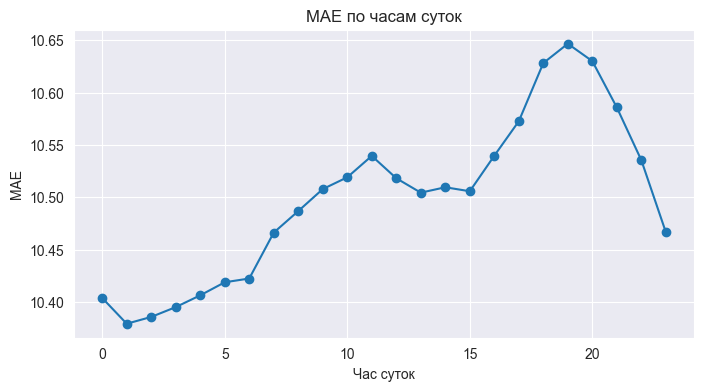

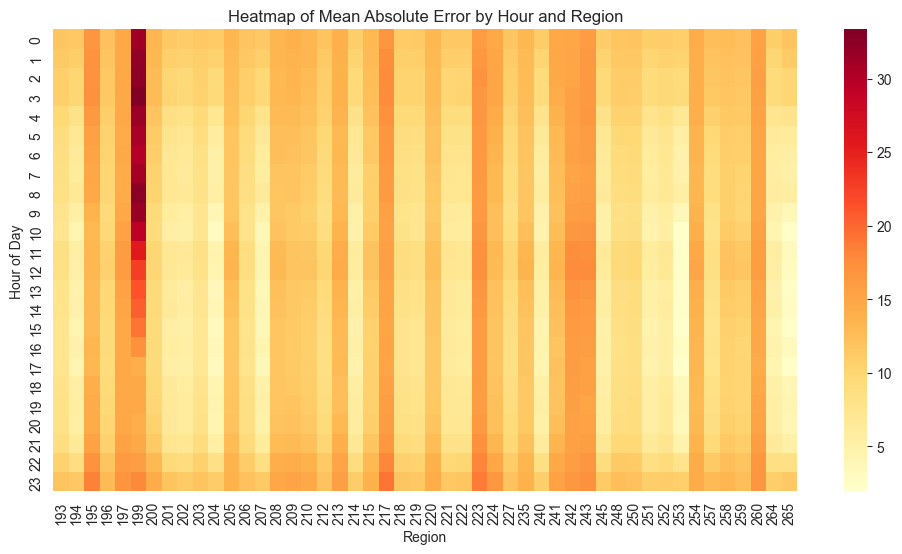

In [66]:
y_test = np.load('y_test1.npy')
y_l = np.load('y_l1.npy')
detailed_analysis(y_test, y_l, top_n=10)

In [67]:
from joblib import dump
dump(scaler_X, 'scaler_X.joblib')  
dump(scaler_y, 'scaler_y.joblib')  

lstm.save('lstm.keras')

**Анализ качества предсказаний модели**

---

## 1. Топ 10 часов суток (по Composite)

* **Лучшее время работы модели** — ночь (0-5 ч).

---

## 2. Топ 10 районов (по MAE)

* **Самый «простой» район** для предсказания — 253 (MAE ≈ 5.1), там модель работает в 2 раза точнее, чем в среднем по городу.
* Второй и третий по точности (265, 204) тоже демонстрируют относительно стабильный спрос.
* Наименее предсказуемые районы (за пределами топ-10) имеют MAE > 15, что указывает на высокую волатильность заказов или малое количество данных.

---

## 3. MAE по часам суток

* **Минимальная MAE** наблюдается около 1-2 ч (\~10.35), т. е. в «тихие» предутренние часы.
* **Пик ошибок** — около 18-19 ч, MAE достигает \~10.65. Скорее всего, модель хуже справляется с дневным изменением спроса.
* В целом колебания MAE по часам невелики (диапазон \~0.2–0.3), что говорит об относительно стабильной работе модели в разные часы.

---

## 4. Тепловая карта средней абсолютной ошибки

* **Яркие вертикальные полосы** (например, регионы ≈ 199 и т. д.) свидетельствуют о районах с высокой ошибкой во всех/почти всех часах.
* В подавляющем большинстве «тихих» районов и часов ошибка лежит в диапазоне 5–10 заказов, тогда как в «проблемных» регионах она превышает 20 заказов.



**Сравнение моделей: LSTM final vs Linear Regression vs LSTM V1 V2**

Моя новая LSTM-модель значительно превосходит простую линейную регрессию и старую модель LSTM по всем ключевым показателям качества:

* **MAE (Mean Absolute Error)**
  LSTM демонстрирует заметно меньшую среднюю абсолютную ошибку, то есть в среднем её прогнозы ближе к реальным значениям.

* **RMSE (Root Mean Squared Error)**
  Благодаря более низкому RMS-показателю LSTM лучше справляется с крупными отклонениями и «пиковыми» значениями спроса.

* **MAPE (Mean Absolute Percentage Error)**
  Низкое процентное отклонение говорит о том, что LSTM сохраняет высокую относительную точность даже в районах с разным уровнем спроса.

* **R² (коэффициент детерминации)**
  Более высокий R² означает, что LSTM объясняет большую долю вариативности реальных данных и в целом лучше подстраивается под их динамику.

* **Composite-метрика**
  Взятие в расчёт объединённого показателя подтверждает превосходство LSTM сразу по всем четырём базовым метрикам.

---

**Вывод:**
LSTM-модель final обеспечивает более точные и устойчивые прогнозы спроса на такси во времени и по районам по сравнению с линейной регрессией, делая её предпочтительным выбором для предиктивной аналитики городской мобильности.
